In [1]:
import IPython
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.ndimage import convolve
from scipy.fftpack import dct, dctn, idctn
from scipy.linalg import circulant
import pywt
from sklearn import linear_model
from IPython.display import clear_output, display
import seaborn as sns

In [2]:
sns.__version__

'0.11.0'

In [3]:
import matplotlib as mpl
mpl.rc('image', cmap='Blues')

In [4]:
width = 128
# img = cv2.imread('./spine_mra.jpg',0)
img = cv2.imread('./SheppLogan_Phantom.png',0)
img = cv2.resize(img, dsize=(width,width))
# img = cv2.imread('/Users/hamid/Projects/DoE/skull_base.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/stem.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/lumbar_spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine_mra.jpg',0)

In [5]:
def sparsity(img):
    return (np.sum(np.abs(img) > 1e-9) / np.prod(img.shape))

In [22]:
def print_progress(n, i):
    
    if i % max(1, (n // 100)) == 0:
        clear_output(wait=True)
        print((i + 1) * 100 // n_reps, "% done")

0.06317138671875


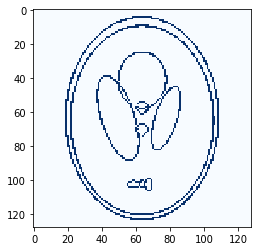

In [7]:
thresh = 0
lap = cv2.Laplacian(img,cv2.CV_64F,ksize=1)
lap_th = np.copy(lap)
lap_th[lap_th < thresh] = 0
lap_th[lap_th != 0] = 1
plt.imshow(lap_th)
print(sparsity(lap_th))

In [8]:
N = np.prod(img.shape)
p = N
print('shape: ', img.shape)
print('dim: ', p)
print('sparsity: ', sparsity(img))

shape:  (128, 128)
dim:  16384
sparsity:  0.42742919921875


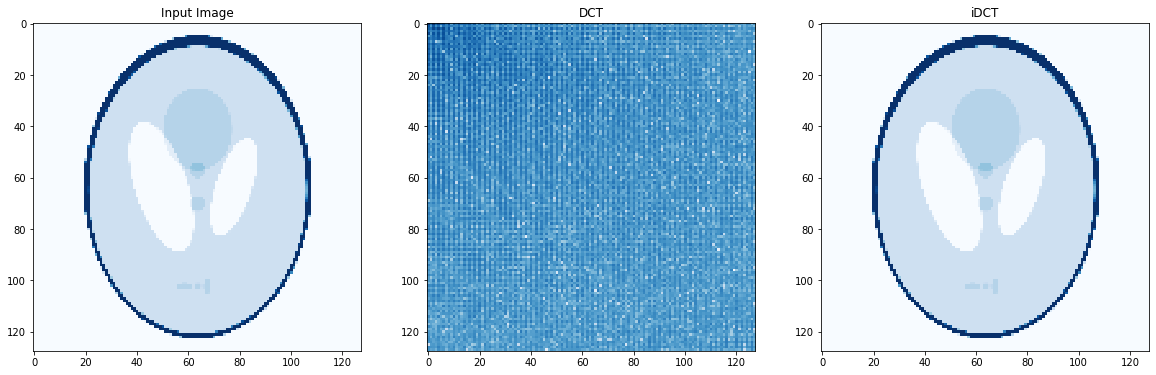

In [9]:
C = dctn(img, norm='ortho')
# Cshift = np.log(np.abs(np.fft.fftshift(C)))
invC = idctn(C, norm='ortho')
plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(img)
plt.title('Input Image')
plt.subplot(132),plt.imshow(np.log(np.abs(C)))
plt.title('DCT')
plt.subplot(133), plt.imshow(invC)
plt.title('iDCT')
plt.show()

In [10]:
d = dct(np.eye(img.shape[0]), norm='ortho')
D = np.kron(d,d).T

In [11]:
X = np.sqrt(N) * D.copy()

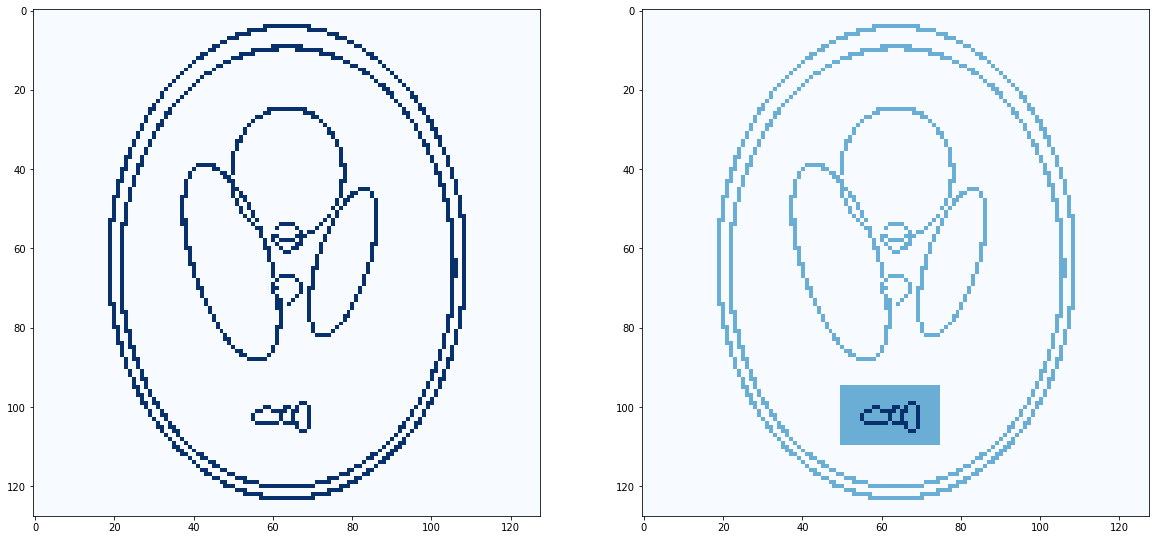

In [12]:
c_arr = np.zeros(img.shape)
c_arr[95:110, 50:75] = 1
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(lap_th)
plt.subplot(122)
plt.imshow(lap_th + c_arr)

In [13]:
N = np.prod(img.shape)
beta = lap_th.reshape(N)
c = c_arr.reshape(N)
c = c / np.sum(np.abs(c))
gamma = beta.T @ c

In [ ]:
import cvxpy as cp

In [ ]:
# N = np.prod(img.shape)

# w = cp.Variable((N), nonneg=True)
# alpha = 0.001
# sdp_const = X.T @ cp.diag(w) @ X - alpha * np.eye(N) >> 0
# constraints = [cp.sum(w) == 1]
# obj = cp.Minimize(cp.MatrixFrac(np.ones(N)/np.sqrt(N), X.T @ cp.diag(w) @ X))
# prob = cp.Problem(obj, constraints)

In [ ]:
# prob.solve(verbose = True)

In [ ]:
N = np.prod(img.shape)
w = cp.Variable((N), nonneg = True)
z = cp.Variable((N))
constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
obj = cp.Minimize(cp.sum(w))
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve(verbose = True, abstol = 1e-5)

In [ ]:
w_opt = w.value / np.sum(w.value)

In [ ]:
#np.savetxt("w_opt.csv", w_opt, delimiter=",")

In [ ]:
w_opt[w_opt < 0]

## Read optimal weights

In [14]:
w_opt = np.loadtxt("w_opt.csv", delimiter=",")

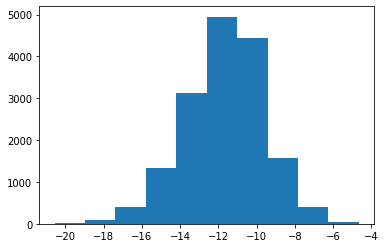

In [15]:
plt.hist(np.log(w_opt[w_opt > 0]))
plt.show()

In [15]:
sigma_opt = np.sqrt(c.T @ np.linalg.solve( X.T @ np.diag(w_opt) @ X, c))

In [16]:
sigma_unif = np.sqrt(c.T @ np.linalg.solve( X.T @ X / N, c))

In [17]:
(sigma_unif / sigma_opt)

4.974722710380467

In [ ]:
np.linalg.eigvalsh(X.T @ np.diag(w_opt) @ X)

In [ ]:
np.isclose(X.T @ X / N, np.eye(N))

In [16]:
from sklearn.linear_model import Lasso, LassoCV
from random import sample

In [17]:
def deb_lasso(x, y, c, u, lasso_tuning, beta_init):
    n = len(y)
    clf = Lasso(alpha=lasso_tuning, fit_intercept=False,
               warm_start=True, max_iter = 999999, copy_X = True,
                normalize = False)
    norms = np.sqrt(np.mean(x**2, axis = 0))
    clf.coef_ = beta_init  #Initialize at truth for faster computation
    clf.fit(x / norms, y)
    beta_hat = clf.coef_ / norms
    gamma_hat = c.T @ beta_hat + u.T @ x.T @ (y - x @ beta_hat) / n
    return [gamma_hat, beta_hat]

In [18]:
signal = X @ beta

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 5 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


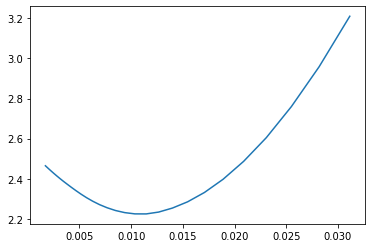

In [22]:
n = N // 2
lambda_theory = np.sqrt(2 * np.log(N)/ n)
indices = np.random.choice(range(N), size=n)

y = signal[indices] + np.random.normal(size=n)

lasso_fit = LassoCV(cv = 10, fit_intercept=False, 
                    alphas=(np.exp(np.arange(-3, 0, 1e-1)))*lambda_theory,
                    n_jobs = -1, max_iter = 999999, verbose=True).fit(X[indices,:],y)

plt.plot(lasso_fit.alphas_, np.mean(lasso_fit.mse_path_, axis = 1))
plt.show()

In [23]:
beta_hat = lasso_fit.coef_
print(gamma)
print("Error: ", np.sum(np.abs(beta - beta_hat)))
print(np.sum(beta))
print(lambda_theory, lasso_fit.alpha_)
cv_lambda = lasso_fit.alpha_

0.10666666666666666
Error:  39.82131403936394
1035.0
0.03441769459380233 0.011456655297828536


# Uniform Sampling

In [19]:
n = N // 2
lambda_theory = np.sqrt(2 * np.log(N)/ n)
u_unif = c
gamma = c.T @ beta
signal = X @ beta

In [25]:
gamma

0.10666666666666666

In [23]:
n = N // 2
n_reps = 50
gammas_unif = np.zeros(n_reps)
var_unif = np.zeros(n_reps)
signal = X @ beta
beta_hat = np.zeros(N)

for i in range(n_reps):
    indices = np.random.choice(range(N), size=n)
    y = signal[indices] + np.random.normal(size=n)    
    gammas_unif[i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, lambda_theory, beta_hat.copy())
    var_unif[i] = c.T @ (X[indices,:].T @ X[indices, :]/n) @ c
    print_progress(n_reps, i)
    print(gammas_unif[i] - gamma)

100 % done
0.0007862064629426263


In [27]:
np.sqrt(var_unif / n)

array([0.00050765, 0.00049979, 0.00048931, 0.00053084, 0.00060925,
       0.0005937 , 0.00059393, 0.00048968, 0.00054464, 0.00052275,
       0.00069289, 0.00068703, 0.00058469, 0.00065332, 0.00056246,
       0.00068461, 0.00055721, 0.00055211, 0.00053984, 0.00063884,
       0.00057336, 0.00062772, 0.0005177 , 0.00057951, 0.00056939,
       0.00062501, 0.00053942, 0.00055284, 0.00061435, 0.00056785,
       0.00051694, 0.00054672, 0.00062234, 0.00054564, 0.00061684,
       0.00051693, 0.00050699, 0.00051354, 0.00058567, 0.00059821,
       0.00048446, 0.00056685, 0.00059418, 0.00058413, 0.00052957,
       0.00049301, 0.00055379, 0.00051242, 0.00057315, 0.00052281])

In [67]:
# np.savetxt(fname = 'unif_dist.csv', X = gammas_unif, delimiter = ',')

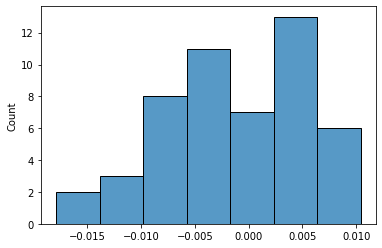

bias:  -0.0014080305750791694
std:  0.006680385271579364
0.000570544330734548


In [24]:
sns.histplot(gammas_unif - gamma)
plt.show()
print("bias: ", np.mean(gammas_unif) - gamma)
print("std: ", np.std(gammas_unif))
print((np.linalg.norm(c) / np.sqrt(n)))

In [ ]:
# np.savetxt("unif_dist.csv", gammas_unif, delimiter=",")

# Optimal Sampling

In [30]:
u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

In [31]:
n_reps = 500
gammas_opt = np.zeros(n_reps)
var_opt = np.zeros(n_reps)

beta_hat = np.zeros(N)
for i in range(n_reps):
    indices = np.random.choice(range(N), size=n, p=w_opt)
    y = signal[indices] + np.random.normal(size=n)

    gammas_opt[i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, cv_lambda, beta_hat.copy())
    var_opt[i] = u_opt.T @ (X[indices, :].T @ X[indices, :] / n) @ u_opt
    
    print_progress(n_reps, i)
    print(gammas_opt[i] - gamma)

99 % done
-3.6640798929371554e-05
-0.0001420447929307983
-2.1107991020952177e-05
-0.00016896968820095948
-0.00010391632106505899


In [46]:
np.savetxt("opt_dist.csv", gammas_opt, delimiter=",")

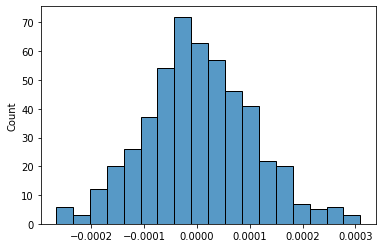

In [32]:
sns.histplot(gammas_opt - gamma)

In [97]:
sns.__version__

'0.9.0'

In [ ]:
sns.distplot((gammas_unif[:100] - gamma))
sns.distplot((gammas[:100] - gamma))

In [ ]:
plt.hist(np.sqrt(n)*(gammas - gamma))
plt.show()
print("bias: ", np.mean(gammas - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas - gamma))))

In [ ]:
plt.hist(np.sqrt(n)*(gammas_unif - gamma))
plt.show()
print("bias: ", np.mean(gammas_unif - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas_unif - gamma))))

In [ ]:
np.random.choice(range(10), 5)

In [ ]:
np.sum(np.isclose(w_opt, 0)) / N

In [ ]:
def grad(w, X, alpha, c):
    N = X.shape[0]
    Sigma = X.T @ np.diag(w) @ X
    u1 = c.T @ np.linalg.solve(Sigma, X.T)
    u2 = np.diag(X @ np.linalg.solve((Sigma - alpha * np.eye(N)), X.T))
    return -(u1 ** 2) - u2 / (N**2)

In [ ]:
def proj(y):
    N = len(y)
    u = sorted(y, reverse=True)
    v = np.cumsum(u)
    rho = np.where( (u + (1 - v)/(np.arange(N)+1)) >0)[0][-1]
    lam = (1 - v[rho])/(rho+1)
    return (y + lam) * ((y + lam)>0)

In [ ]:
n_iter = 1
step_size = 1e-3
alpha = 0.01
# w = np.ones(N) / N
for i in range(n_iter):
    g = grad(w, X, alpha, c)
    u = w - step_size * g / np.linalg.norm(g)
    print(np.max(np.abs(u)))
    w = proj(u)

In [ ]:
c.T @ np.linalg.solve(X.T @ np.diag(w) @ X, c)

In [ ]:
c.T @ np.linalg.solve(X.T @ X / N, c)

In [ ]:
np.linalg.eigvalsh(X.T @ np.diag(w) @ X)

In [48]:
np.std(gammas_unif)

0.0021481262281413346

In [50]:
np.sqrt(var_unif / n)

array([0.04833135, 0.0539817 , 0.05405447, 0.04636475, 0.05635212,
       0.05249686, 0.05237413, 0.04883616, 0.05189109, 0.05853423,
       0.05010844, 0.05322367, 0.0524443 , 0.04890065, 0.04737835,
       0.04605379, 0.04945246, 0.05107507, 0.03927172, 0.04786901,
       0.05038101, 0.0511219 , 0.05625847, 0.05280173, 0.05475372,
       0.05746163, 0.0582159 , 0.0527429 , 0.04552878, 0.05017928,
       0.05309888, 0.04737212, 0.05406233, 0.05490193, 0.06182825,
       0.04239881, 0.05065651, 0.05383663, 0.04922077, 0.06381016,
       0.04912   , 0.04517829, 0.06224627, 0.05054573, 0.05146707,
       0.05269692, 0.0358062 , 0.05714291, 0.05227873, 0.04421223,
       0.04884365, 0.05107931, 0.05071808, 0.04371633, 0.05461859,
       0.04364397, 0.04408163, 0.05462478, 0.05400427, 0.05739918,
       0.04850927, 0.05176407, 0.05551698, 0.03893083, 0.04722276,
       0.04658414, 0.04646494, 0.04689034, 0.05246893, 0.05473616,
       0.04299298, 0.04858755, 0.06137142, 0.0495055 , 0.05471

In [54]:
 np.std(gammas_opt)

0.00010150983234139877

In [55]:
np.sqrt(var_opt / n)

array([0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011469,
       0.00011469, 0.00011469, 0.00011469, 0.00011469, 0.00011